In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.linalg import hilbert
%matplotlib inline

In [2]:
RTOL = 0.
ATOL = 1e-12
SEED = 17

## Linear systems

<img src="https://i.ytimg.com/vi/7ujEpq7MWfE/maxresdefault.jpg" width="400" />

Given square matrix $A_{nxn}$, and vector $\mathbf{b}$, find such vector $\mathbf{x}$ that $A \cdot \mathbf{x} = \mathbf{b}$.

### Example 1
$$ 
\begin{bmatrix} 10 & -1 & 2 & 0 \\ -1 & 11 & -1 & 3 \\ 2 & -1 & 10 & -1 \\ 0 & 3 & -1 & 8 \end{bmatrix} \cdot
\begin{bmatrix} x_1 \\ x_2 \\ x_3 \\ x_4 \end{bmatrix} =
\begin{bmatrix} 6 \\ 25 \\ -11 \\ 15 \end{bmatrix} 
$$
Equation above can be rewritten as
$$
\left\{
\begin{aligned} 
10x_1 - x_2 + 2x_3 + 0x_4 &= 6 \\
-x_1 + 11x_2 + -x_3 + 3x_4 &= 25 \\
2x_1 - x_2 + 10x_3 - x_4 &= -11 \\
0x_1 + 3x_2 - 2x_3 + 8x_4 &= 15
\end{aligned} 
\right. 
$$

We can easily check that $\mathbf{x} = [1, 2, -1, 1]$ is a solution.

This particular example has only one solution, but generaly speaking matrix equation can have **no, one or infinite number** of solutions. 

Some methods can found them all(eg. Gauss), but some can only converge to one solution(eg. Seidel, Jacobi).

To start, let's define some helper functions

In [3]:
def is_square(a):
    return a.shape[0] == a.shape[1]

In [4]:
def has_solutions(a, b):
    return np.linalg.matrix_rank(a) == np.linalg.matrix_rank(np.append(a, b[np.newaxis].T, axis=1))

### Diagonally dominance
We say that matrix $A_{nxn}$ is **diagonally dominant** iff

$$ |a_{ii}| \geq \sum_{j\neq i} |a_{ij}|, \quad \forall i=1, n \, $$

equivalent

$$ 2 \cdot |a_{ii}| \geq \sum_{j = 1, n} |a_{ij}|, \quad \forall i=1, n \, $$

Also we say that matrix $A_{nxn}$ is **strictly diagonally dominant** iff it's diagonally dominant and

$$ \exists i : |a_{ii}| > \sum_{j\neq i} |a_{ij}|$$

In [5]:
def is_dominant(a):
    return np.all(np.abs(a).sum(axis=1) <= 2 * np.abs(a).diagonal()) and \
        np.any(np.abs(a).sum(axis=1) < 2 * np.abs(a).diagonal())

In [6]:
def make_dominant(a):
    for i in range(a.shape[0]):
        a[i][i] = max(abs(a[i][i]), np.abs(a[i]).sum() - abs(a[i][i]) + 1)
    return a

**NOTE!** All *generate* functions will return already **strictly diagonally dominant** matrices 

In [7]:
def generate_random(n):
    np.random.seed(SEED)
    return make_dominant(np.random.rand(n, n) * n), np.random.rand(n) * n

In [8]:
def generate_hilbert(n):
    return make_dominant(sp.linalg.hilbert(n)), np.arange(1, n + 1, dtype=np.float)

In [9]:
def solve(a, b, debug=False):
    return np.linalg.solve(a, b),

### Gauss method

To perform row reduction on a matrix, one uses a sequence of elementary row operations to modify the matrix until the lower left-hand corner of the matrix is filled with zeros, as much as possible. There are three types of elementary row operations: 

 1. Swapping two rows
 2. Multiplying a row by a non-zero number
 3. Adding a multiple of one row to another row. 

Using these operations, a matrix can always be transformed into an upper triangular matrix, and in fact one that is in row echelon form. Once all of the leading coefficients (the left-most non-zero entry in each row) are 1, and every column containing a leading coefficient has zeros elsewhere, the matrix is said to be in reduced row echelon form. This final form is unique; in other words, it is independent of the sequence of row operations used. For example, in the following sequence of row operations (where multiple elementary operations might be done at each step), the third and fourth matrices are the ones in row echelon form, and the final matrix is the unique reduced row echelon form.

$$\left[\begin{array}{rrr|r}
1 & 3 & 1 & 9 \\
1 & 1 & -1 & 1 \\
3 & 11 & 5 & 35
\end{array}\right]\to
\left[\begin{array}{rrr|r}
1 & 3 & 1 & 9 \\
0 & -2 & -2 & -8 \\
0 & 2 & 2 & 8
\end{array}\right]\to
\left[\begin{array}{rrr|r}
1 & 3 & 1 & 9 \\
0 & -2 & -2 & -8 \\
0 & 0 & 0 & 0
\end{array}\right]\to
\left[\begin{array}{rrr|r}
1 & 0 & -2 & -3 \\
0 & 1 & 1 & 4 \\
0 & 0 & 0 & 0
\end{array}\right] $$

Using row operations to convert a matrix into reduced row echelon form is sometimes called **Gauss–Jordan elimination**. Some authors use the term Gaussian elimination to refer to the process until it has reached its upper triangular, or (non-reduced) row echelon form. For computational reasons, when solving systems of linear equations, it is sometimes preferable to stop row operations before the matrix is completely reduced.


In [10]:
def gauss(a, b, debug=False):
    assert is_square(a) and has_solutions(a, b)
    
    a = np.append(a.copy(), b[np.newaxis].T, axis=1)
    i = 0
    k = 0
    while i < a.shape[0]:
        r = np.argmax(a[i:, i]) + i
        a[[i, r]] = a[[r, i]]
        
        if a[i][i] == 0:
            break
        
        for j in range(a.shape[0]):
            if j == i:
                continue
            a[j] -= (a[j][i] / a[i][i]) * a[i]
        a[i] = a[i] / a[i][i]
        i += 1
        
    assert np.count_nonzero(a[i:]) == 0
    return a[:, -1],

### Gauss-Seidel method

The Gauss–Seidel method is an **iterative technique** for solving a square system of $n$ linear equations with unknown $x$:

$$ A \mathbf{x} = \mathbf{b} $$

It is defined by the iteration

$$ L_* \mathbf{x}^{(k+1)} = \mathbf{b} - U \mathbf{x}^{(k)}, $$

where $\mathbf{x}^{(k)}$ is the $k$-th approximation or iteration of $\mathbf{x},\,\mathbf{x}^{k+1}$ is the next or $k + 1$ iteration of $\mathbf{x}$, and the matrix $A$ is decomposed into a lower triangular component $L_*$, and a strictly upper triangular component $U: A = L_* + U $.

In more detail, write out $A$, $\mathbf{x}$ and $\mathbf{b}$ in their components:

$$A=\begin{bmatrix} a_{11} & a_{12} & \cdots & a_{1n} \\ a_{21} & a_{22} & \cdots & a_{2n} \\ \vdots & \vdots & \ddots & \vdots \\a_{n1} & a_{n2} & \cdots & a_{nn} \end{bmatrix}, \qquad  \mathbf{x} = \begin{bmatrix} x_{1} \\ x_2 \\ \vdots \\ x_n \end{bmatrix} , \qquad  \mathbf{b} = \begin{bmatrix} b_{1} \\ b_2 \\ \vdots \\ b_n \end{bmatrix}.$$

Then the decomposition of $A$ into its lower triangular component and its strictly upper triangular component is given by:

$$A=L_*+U \qquad \text{where} \qquad L_* = \begin{bmatrix} a_{11} & 0 & \cdots & 0 \\ a_{21} & a_{22} & \cdots & 0 \\ \vdots & \vdots & \ddots & \vdots \\a_{n1} & a_{n2} & \cdots & a_{nn} \end{bmatrix}, \quad U = \begin{bmatrix} 0 & a_{12} & \cdots & a_{1n} \\ 0 & 0 & \cdots & a_{2n} \\ \vdots & \vdots & \ddots & \vdots \\0 & 0 & \cdots & 0 \end{bmatrix}.$$

The system of linear equations may be rewritten as:

$$L_* \mathbf{x} = \mathbf{b} - U \mathbf{x} $$

The Gauss–Seidel method now solves the left hand side of this expression for $\mathbf{x}$, using previous value for $\mathbf{x}$ on the right hand side. Analytically, this may be written as:

$$ \mathbf{x}^{(k+1)} = L_*^{-1} (\mathbf{b} - U \mathbf{x}^{(k)}). $$

However, by taking advantage of the triangular form of $L_*$, the elements of $\mathbf{x}^{(k + 1)}$ can be computed sequentially using **forward substitution**:

$$ x^{(k+1)}_i  = \frac{1}{a_{ii}} \left(b_i - \sum_{j=1}^{i-1}a_{ij}x^{(k+1)}_j - \sum_{j=i+1}^{n}a_{ij}x^{(k)}_j \right),\quad i=1,2,\dots,n. $$

The procedure is generally continued until the changes made by an iteration are below some tolerance.


In [11]:
def seidel(a, b, x0 = None, limit=20000, debug=False):
    assert is_square(a) and is_dominant(a) and has_solutions(a, b)
    
    if x0 is None:
        x0 = np.zeros_like(b, dtype=np.float)
    x = x0.copy()
    for k in range(limit):
        tx = x.copy()
        for i in range(a.shape[0]):
            x[i] = (b[i] - a[i, :].dot(x)) / a[i][i] + x[i]
        if debug:
            print(x)
        if np.allclose(x, tx, atol=ATOL, rtol=RTOL):
            return x, k
    return x, limit

### Jacobi method

The Jacobi method is an **iterative technique** for solving a square system of $n$ linear equations with unknown $x$:

$$ A \mathbf{x} = \mathbf{b} $$

where

$$A=\begin{bmatrix} a_{11} & a_{12} & \cdots & a_{1n} \\ a_{21} & a_{22} & \cdots & a_{2n} \\ \vdots & \vdots & \ddots & \vdots \\a_{n1} & a_{n2} & \cdots & a_{nn} \end{bmatrix}, \qquad  \mathbf{x} = \begin{bmatrix} x_{1} \\ x_2 \\ \vdots \\ x_n \end{bmatrix} , \qquad  \mathbf{b} = \begin{bmatrix} b_{1} \\ b_2 \\ \vdots \\ b_n \end{bmatrix}.$$

Then $A$ can be decomposed into a diagonal component $D$, and the remainder $R$:

$$A=D+R \qquad \text{where} \qquad D = \begin{bmatrix} a_{11} & 0 & \cdots & 0 \\ 0 & a_{22} & \cdots & 0 \\ \vdots & \vdots & \ddots & \vdots \\0 & 0 & \cdots & a_{nn} \end{bmatrix} \text{ and } R = \begin{bmatrix} 0 & a_{12} & \cdots & a_{1n} \\ a_{21} & 0 & \cdots & a_{2n} \\ \vdots & \vdots & \ddots & \vdots \\ a_{n1} & a_{n2} & \cdots & 0 \end{bmatrix}. $$

The solution is then obtained iteratively via
$$ \mathbf{x}^{(k+1)} = D^{-1} (\mathbf{b} - R \mathbf{x}^{(k)}), $$

where $\mathbf{x}^{(k)}$ is the $k$-th approximation or iteration of $\mathbf{x}$ and $\mathbf{x}^{(k+1)}$ is the next or $k + 1$ iteration of $\mathbf{x}$. The element-based formula is thus:

$$ x^{(k+1)}_i  = \frac{1}{a_{ii}} \left(b_i -\sum_{j\ne i}a_{ij}x^{(k)}_j\right),\quad i=1,2,\ldots,n. $$

The computation of $x_{i}^{(k+1)}$ requires each element in $\mathbf{x}^k$ except itself. Unlike the Gauss–Seidel method, we can't overwrite $x_i^k$ with $x_i^{(k+1)}$, as that value will be needed by the rest of the computation. The minimum amount of storage is two vectors of size $n$.

In [12]:
def jacobi(a, b, x0 = None, limit=20000, debug=False):
    assert is_square(a) and is_dominant(a) and has_solutions(a, b)
    
    if x0 is None:
        x0 = np.zeros_like(b, dtype=np.float)
    x = x0.copy()
    for k in range(limit):
        tx = x.copy()
        for i in range(a.shape[0]):
            x[i] = (b[i] - a[i, :].dot(tx)) / a[i][i] + tx[i]
        if debug:
            print(x)
        if np.allclose(x, tx, atol=ATOL, rtol=RTOL):
            return x, k
    return x, limit

### Evaluation

To evaluate algorithm we are going to calculate
$$ score = || A \cdot \mathbf{x^*} - \mathbf{b} || $$

where $\mathbf{x}^*$ is a result of algorithm.

In [13]:
def norm(a, b, res):
    return np.linalg.norm(a.dot(res) - b)

In [14]:
def run(method, a, b, verbose=False, **kwargs):
    if not verbose:
        print("-" * 100)
        print(method.__name__.upper())
    res = method(a, b, **kwargs)
    score = norm(a, b, res[0])
    if not verbose:
        print("res =", res)
        print("score =", score)
    return score

## Back to examples
### Example 1

Do you remember example from the problem statement? Now, we are going to see how iterative algorithms converges for that example.

In [15]:
a4 = np.array([[10., -1., 2., 0.],
              [-1., 11., -1., 3.],
              [2., -1., 10., -1.],
              [0., 3., -1., 8.]])
print(a4)
b = np.array([6., 25., -11., 15.])
print("b =", b)

_ = run(solve, a4, b)
_ = run(gauss, a4, b)
_ = run(seidel, a4, b)
_ = run(jacobi, a4, b)

[[ 10.  -1.   2.   0.]
 [ -1.  11.  -1.   3.]
 [  2.  -1.  10.  -1.]
 [  0.   3.  -1.   8.]]
b = [  6.  25. -11.  15.]
----------------------------------------------------------------------------------------------------
SOLVE
res = (array([ 1.,  2., -1.,  1.]),)
score = 0.0
----------------------------------------------------------------------------------------------------
GAUSS
res = (array([ 1.,  2., -1.,  1.]),)
score = 0.0
----------------------------------------------------------------------------------------------------
SEIDEL
res = (array([ 1.,  2., -1.,  1.]), 13)
score = 3.31290550548e-13
----------------------------------------------------------------------------------------------------
JACOBI
res = (array([ 1.,  2., -1.,  1.]), 34)
score = 2.92144767667e-12


### Seidel vs Jacobi
Here is tricky example of linear system, when **Jacobi** method converges faster than **Gauss-Seidel**.

As you will see, Jacobi needs only **1 iteration** to find an answer, while Gauss-Seidel needs **over 10 iterations** to find approximate solution.

In [16]:
a4 = np.array([[1., -1/8, 1/32, 1/64],
              [-1/2, 2., 1/16, 1/32],
              [-1., 1/4, 4., 1/16],
              [-1., 1/4, 1/8, 8.]])
print(a4)
b = np.array([1., 4., 16., 64.])
print("b =", b)

_ = run(solve, a4, b)
_ = run(gauss, a4, b)
_ = run(seidel, a4, b)
_ = run(jacobi, a4, b)

[[ 1.       -0.125     0.03125   0.015625]
 [-0.5       2.        0.0625    0.03125 ]
 [-1.        0.25      4.        0.0625  ]
 [-1.        0.25      0.125     8.      ]]
b = [  1.   4.  16.  64.]
----------------------------------------------------------------------------------------------------
SOLVE
res = (array([ 1.,  2.,  4.,  8.]),)
score = 1.42108547152e-14
----------------------------------------------------------------------------------------------------
GAUSS
res = (array([ 1.,  2.,  4.,  8.]),)
score = 1.42125893328e-14
----------------------------------------------------------------------------------------------------
SEIDEL
res = (array([ 1.,  2.,  4.,  8.]), 10)
score = 8.881784197e-16
----------------------------------------------------------------------------------------------------
JACOBI
res = (array([ 1.,  2.,  4.,  8.]), 1)
score = 0.0


### Hilbert matrices

Now, let's have a look at **Hilbert matrix**. It's said that non-iterative methods should do bad here. Proof?

In [17]:
a, b = generate_hilbert(1000)

print("SOLVE =", run(solve, a, b, verbose=True))
print("GAUSS =", run(gauss, a, b, verbose=True))
print("SEIDEL =", run(seidel, a, b, x0=np.zeros_like(b, dtype=np.float), verbose=True))
print("JACOBI =", run(jacobi, a, b, x0=np.zeros_like(b, dtype=np.float), verbose=True))

SOLVE = 2.30924651019e-11
GAUSS = 2.85356368892e-11
SEIDEL = 4.87050483505e-12
JACOBI = 2.20288165302e-11


As we can see, it's true for huge $n>1000$, that direct methods works bad on Hilbert matrices. But how about the size of matrix? Is $n=500$ enough?

In [18]:
def plot_hilbert_score_by_matrix_size(method, sizes):
    scores = np.zeros_like(sizes, dtype=np.float)
    for i in range(len(sizes)):
        a, b = generate_hilbert(sizes[i])
        scores[i] = run(method, a, b, verbose=True)
    plt.plot(sizes, scores, label=method.__name__)

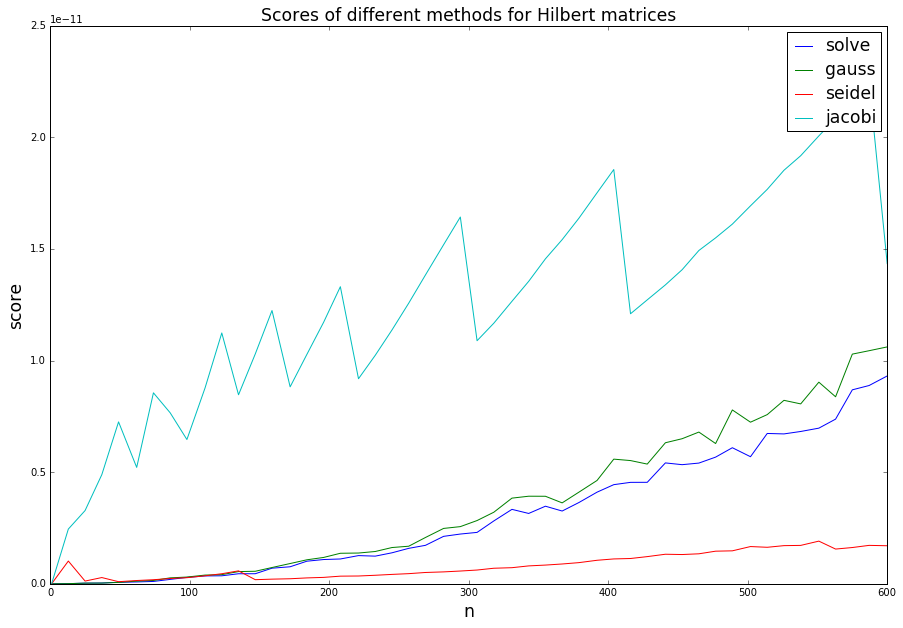

In [19]:
sizes = np.linspace(1, 600, num=50, dtype=np.int)

plt.figure(figsize=(15, 10))
plot_hilbert_score_by_matrix_size(solve, sizes)
plot_hilbert_score_by_matrix_size(gauss, sizes)
plot_hilbert_score_by_matrix_size(seidel, sizes)
plot_hilbert_score_by_matrix_size(jacobi, sizes)

plt.title("Scores of different methods for Hilbert matrices") \
   .set_fontsize("xx-large")
plt.xlabel("n").set_fontsize("xx-large")
plt.ylabel("score").set_fontsize("xx-large")
legend = plt.legend(loc="upper right")
for label in legend.get_texts():
    label.set_fontsize("xx-large")
plt.show()

### Random matrices

It's time to test our methods on random generated matrices. 

To be deterministic, we are going to set seed equals to $17$ every time, we call *generate_random(...)*


In [20]:
a, b = generate_random(20)

_ = run(solve, a, b)
_ = run(gauss, a, b)
_ = run(seidel, a, b)
_ = run(jacobi, a, b)

----------------------------------------------------------------------------------------------------
SOLVE
res = (array([-0.00449031,  0.02294164, -0.00977048,  0.05280079,  0.01981815,
       -0.00741453, -0.00618963, -0.01628833,  0.05707874,  0.05046688,
        0.05052913,  0.09124976,  0.02577862,  0.06852756,  0.00043723,
        0.0701774 , -0.01765149, -0.02584028, -0.00838885,  0.03311334]),)
score = 1.18913126803e-14
----------------------------------------------------------------------------------------------------
GAUSS
res = (array([-0.00449031,  0.02294164, -0.00977048,  0.05280079,  0.01981815,
       -0.00741453, -0.00618963, -0.01628833,  0.05707874,  0.05046688,
        0.05052913,  0.09124976,  0.02577862,  0.06852756,  0.00043723,
        0.0701774 , -0.01765149, -0.02584028, -0.00838885,  0.03311334]),)
score = 1.04148151432e-14
----------------------------------------------------------------------------------------------------
SEIDEL
res = (array([-0.00449031,  0.

### Runtime
Now, let's compare our methods by actual time running. 

To have more accurate results, we need to run them on large matrix(eg. random $200x200$).

In [21]:
a, b = generate_random(200)

%timeit run(solve, a, b, verbose=True)
%timeit run(gauss, a, b, verbose=True)
%timeit run(seidel, a, b, verbose=True)
%timeit run(jacobi, a, b, verbose=True)

1000 loops, best of 3: 562 µs per loop
10 loops, best of 3: 116 ms per loop
100 loops, best of 3: 13 ms per loop
1 loop, best of 3: 6.94 s per loop


### Convergence speed

We already have compared methods by accuracy and time, but how about speed. 

Now we are going to show what will be the error of method after some number of iterations. To be more clear we use **logarithmic x-scale**.

In [22]:
def plot_convergence(method, a, b, limits):
    scores = np.zeros_like(limits, dtype=np.float)
    for i in range(len(limits)):
        scores[i] = run(method, a, b, x0 = np.zeros_like(b, dtype=np.float), limit=limits[i], verbose=True)
    plt.plot(limits, scores, label=method.__name__)

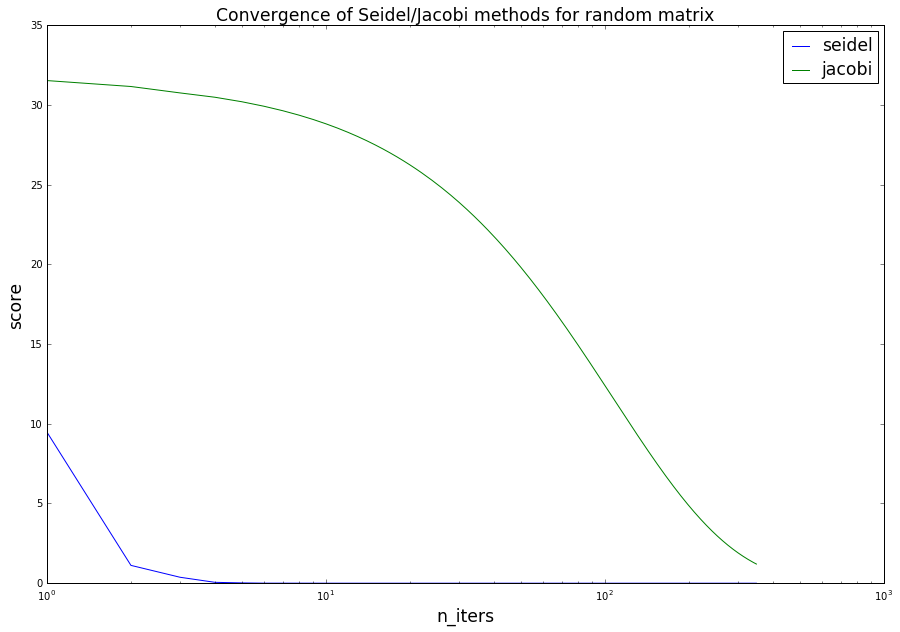

In [23]:
a, b = generate_random(15)
limits = np.arange(0, 350)

plt.figure(figsize=(15, 10))
plot_convergence(seidel, a, b, limits)
plot_convergence(jacobi, a, b, limits)
plt.title("Convergence of Seidel/Jacobi methods for random matrix").set_fontsize("xx-large")
plt.xlabel("n_iters").set_fontsize("xx-large")
plt.ylabel("score").set_fontsize("xx-large")
plt.xscale("log")
legend = plt.legend(loc="upper right")
for label in legend.get_texts():
    label.set_fontsize("xx-large")
plt.show()